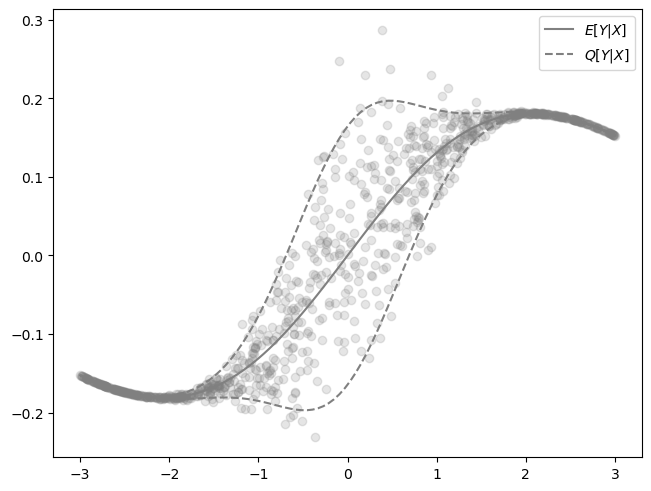

In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(0)
n_samples = int(2e4)
x = rng.uniform(low=-3, high=3, size=n_samples)
X = x.reshape((n_samples, 1))


def true_y_mean(x):
    return expit(x) - 0.5 - 0.1 * x


def true_y_std(x):
    return 0.1 * np.exp(-((x - 0.0) ** 2) / 0.9)


y = rng.normal(loc=true_y_mean(x), scale=true_y_std(x))
X_train, X_test, x_train, x_test, y_train, y_test = train_test_split(
    X, x, y, test_size=0.5, random_state=0
)


def plot_data_generating_process(
    x,
    y,
    plot_data=True,
    max_scatter_points=1_000,
    plot_mean=True,
    plot_005_quantile=True,
    plot_095_quantile=True,
    color="gray",
    highlight_indices=None,
    ax=None,
):
    x_grid = np.linspace(x.min(), x.max(), 100)
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)
    if plot_data:
        ax.scatter(
            x=x[:max_scatter_points],
            y=y[:max_scatter_points],
            alpha=0.2,
            color=color,
        )

    if plot_mean:
        ax.plot(x_grid, true_y_mean(x_grid), label="$E[Y|X]$", color=color)
    if plot_095_quantile:
        ax.plot(
            x_grid,
            true_y_mean(x_grid) + 1.645 * true_y_std(x_grid),
            linestyle="--",
            color=color,
        )
    if plot_005_quantile:
        ax.plot(
            x_grid,
            true_y_mean(x_grid) - 1.645 * true_y_std(x_grid),
            linestyle="--",
            label=r"$Q[Y|X]$",
            color=color,
        )
    if plot_data and highlight_indices:
        for i, idx in enumerate(highlight_indices):
            ax.scatter(
                x=[x[idx]], y=[y[idx]], alpha=1, marker="^", s=100, color=f"C{i}"
            )
    if plot_mean or plot_005_quantile:
        ax.legend()


plot_data_generating_process(x_train, y_train)

In [2]:
import pandas as pd

df_train = pd.DataFrame({"x": x_train, "y": y_train})
df_train.query("y < -0.2").sort_values(by="y", ascending=True)

,x,y
6729,0.002899,-0.327283
2329,0.200093,-0.297277
2217,0.142154,-0.280025
5662,-0.451823,-0.277595
6203,-0.647726,-0.270522
...,...,...
1467,-0.272495,-0.202639
6239,-0.875603,-0.201063
9764,-0.872463,-0.200888
1194,0.247952,-0.200864


In [3]:
highlight_indices = [800, 114, 123, 509, 807, 361]
df_train.iloc[highlight_indices]

,x,y
800,-2.466653,-0.174983
114,1.237586,0.179628
123,-2.953453,-0.155072
509,-2.723120,-0.166097
807,-2.107480,-0.180656
361,0.856156,0.151765


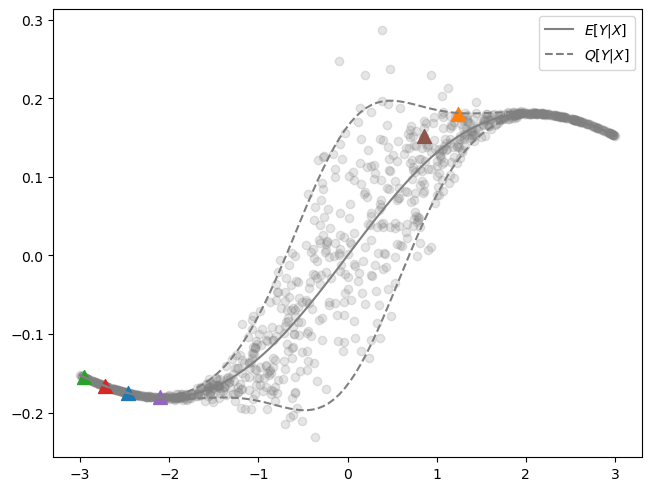

In [4]:
plot_data_generating_process(x_train, y_train, highlight_indices=highlight_indices)

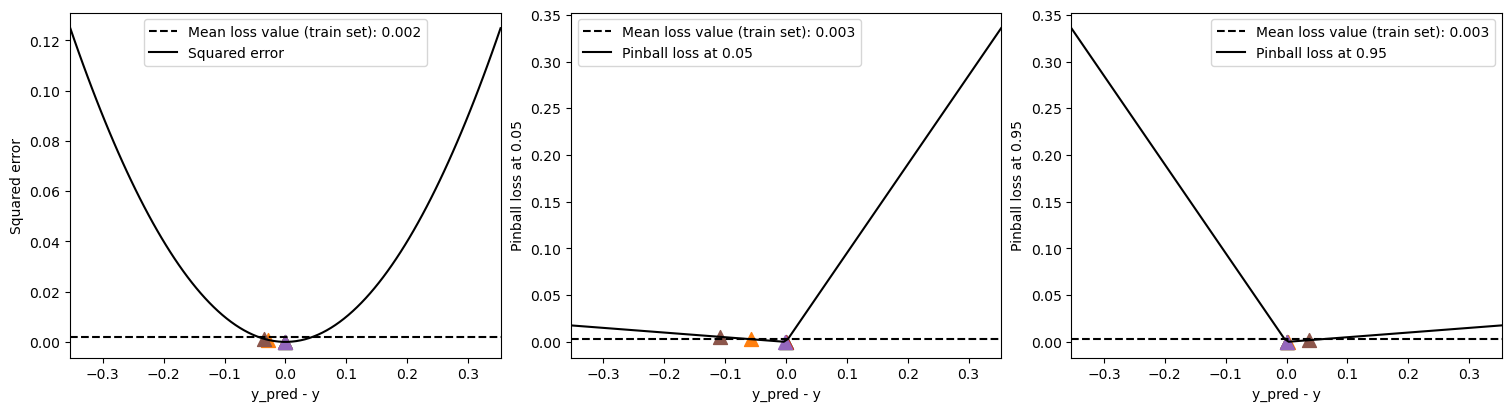

In [11]:
from sklearn.metrics import mean_squared_error, mean_pinball_loss
from functools import partial


def make_loss_function(loss_name, quantile=0.5, return_label=True):
    if loss_name == "squared_error":
        if return_label:
            return mean_squared_error, "MSE loss"
        else:
            return mean_squared_error
    elif loss_name == "quantile":
        if return_label:
            return (
                partial(mean_pinball_loss, alpha=quantile),
                f"Pinball loss (q={quantile:.2f})",
            )
        else:
            return partial(mean_pinball_loss, alpha=quantile)
    else:
        raise ValueError(f"Unsupported loss {loss_name:!r}")


def plot_loss_function(
    loss_fun,
    loss_label,
    y_true,
    y_pred,
    highlight_indices=None,
    diff_grid_range=None,
    data_name="train",
    mean_loss=True,
    legend=True,
    ax=None,
):
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    if diff_grid_range is None:
        # Maximum absolute diff observed for a 0 prediction (e.g. a linear
        # model init).
        max_abs = np.abs(y_true).max()
        diff_grid_range = (-max_abs, max_abs)

    if mean_loss:
        mean_loss_value = loss_fun(y_true, y_pred)
        ax.hlines(
            mean_loss_value,
            diff_grid_range[0],
            diff_grid_range[1],
            label=f"Mean loss value ({data_name} set): {mean_loss_value:.3f}",
            linestyle="--",
            color="black",
        )
    n_steps = 100
    y_pred_grid = np.linspace(diff_grid_range[0], diff_grid_range[1], n_steps)
    ax.plot(
        y_pred_grid,
        [loss_fun([0], [y_pred_grid_i]) for y_pred_grid_i in y_pred_grid],
        color="black",
        label=loss_label,
    )
    if highlight_indices:
        for i, idx in enumerate(highlight_indices):
            loss_value = loss_fun([y_true[idx]], [y_pred[idx]])
            ax.scatter(
                y_pred[idx] - y_true[idx],
                loss_value,
                color=f"C{i}",
                s=100,
                marker="^",
            )
    ax.set(xlim=diff_grid_range, xlabel="y_pred - y", ylabel=loss_label)
    if legend:
        ax.legend()


fig, axs = plt.subplots(ncols=3, figsize=(15, 4), constrained_layout=True)

plot_loss_function(
    mean_squared_error,
    "Squared error",
    y_train,
    true_y_mean(x_train),
    highlight_indices=highlight_indices,
    ax=axs[0],
)
plot_loss_function(
    partial(mean_pinball_loss, alpha=0.05),
    "Pinball loss at 0.05",
    y_train,
    true_y_mean(x_train) - 1.645 * true_y_std(x_train),
    highlight_indices=highlight_indices,
    ax=axs[1],
)
plot_loss_function(
    partial(mean_pinball_loss, alpha=0.95),
    "Pinball loss at 0.95",
    y_train,
    true_y_mean(x_train) + 1.645 * true_y_std(x_train),
    highlight_indices=highlight_indices,
    ax=axs[2],
)

In [12]:
from sklearn.base import RegressorMixin
from sklearn.linear_model._base import LinearModel
from scipy.optimize import minimize
import warnings
from sklearn.exceptions import ConvergenceWarning


def pinball_loss_gradient(X, y, coef, intercept, quantile):
    y_pred = X @ coef + intercept
    error = y - y_pred
    mask = (error >= 0).astype(X.dtype)
    weights = -quantile * mask + (1 - quantile) * (1 - mask)
    grad_coef = weights @ X / len(y)
    grad_intercept = weights.mean()
    return grad_coef, grad_intercept


class NaiveRegressor(RegressorMixin, LinearModel):

    def __init__(
        self,
        loss="squared_error",
        quantile=0.5,
        alpha=0,
        l1_ratio=0.1,
        tol=1e-6,
        max_iter=10_000,
        verbose=False,
    ):
        self.loss = loss
        self.quantile = quantile
        self.max_iter = max_iter
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        params = np.zeros(X.shape[1] + 1)
        n_iter_holder = np.zeros(1, dtype=np.int32)

        loss_fun = make_loss_function(
            self.loss, quantile=self.quantile, return_label=False
        )

        def objective(params):
            return (
                loss_fun(y, X @ params[:-1] + params[-1])
                + self.l1_ratio * self.alpha * np.linalg.norm(params[:-1], 1)
                + (1 - self.l1_ratio) * self.alpha * np.linalg.norm(params[:-1], 2) ** 2
            )

        def iter_cb(params):
            n_iter_holder[0] += 1
            n_iter = n_iter_holder[0]
            if self.verbose and n_iter % 10 == 0:
                loss = loss_fun(y, X @ params[:-1] + params[-1])
                print(f"{self.loss} at iteration {n_iter}: {loss:.6f}")
            if n_iter_holder[0] >= self.max_iter:
                raise StopIteration()

        if self.max_iter > 0:
            result = minimize(objective, params, tol=self.tol, callback=iter_cb)
            params = result.x
        self.coef_ = params[:-1]
        self.intercept_ = params[-1]
        self.n_iter_ = n_iter_holder[0]
        if self.n_iter_ == self.max_iter:
            warnings.warn(
                f"Fail to converge after reaching {self.max_iter} iterations",
                ConvergenceWarning,
            )
        return self

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

n_knots = 10

shared_params = dict(
    tol=1e-4,
    alpha=1e-6,
    l1_ratio=0.1,
)
poly_reg_record = []
poly_reg_max_iters = [0, 5, 10, 50, 100]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    for max_iter in poly_reg_max_iters:
        shared_params["max_iter"] = max_iter
        poly_reg_triplet = (
            make_pipeline(
                SplineTransformer(n_knots=n_knots), NaiveRegressor(**shared_params)
            ).fit(X_train, y_train),
            make_pipeline(
                SplineTransformer(n_knots=n_knots),
                NaiveRegressor(loss="quantile", quantile=0.05, **shared_params),
            ).fit(X_train, y_train),
            make_pipeline(
                SplineTransformer(n_knots=n_knots),
                NaiveRegressor(loss="quantile", quantile=0.95, **shared_params),
            ).fit(X_train, y_train),
        )
        print(
            tuple(int(getattr(e.steps[-1][1], "n_iter_", 1)) for e in poly_reg_triplet)
        )
        poly_reg_record.append(dict(
            max_iter=max_iter,
            model_triplet=poly_reg_triplet,
        ))

(0, 0, 0)
(5, 5, 5)
(10, 10, 10)
(29, 50, 50)
(29, 100, 100)


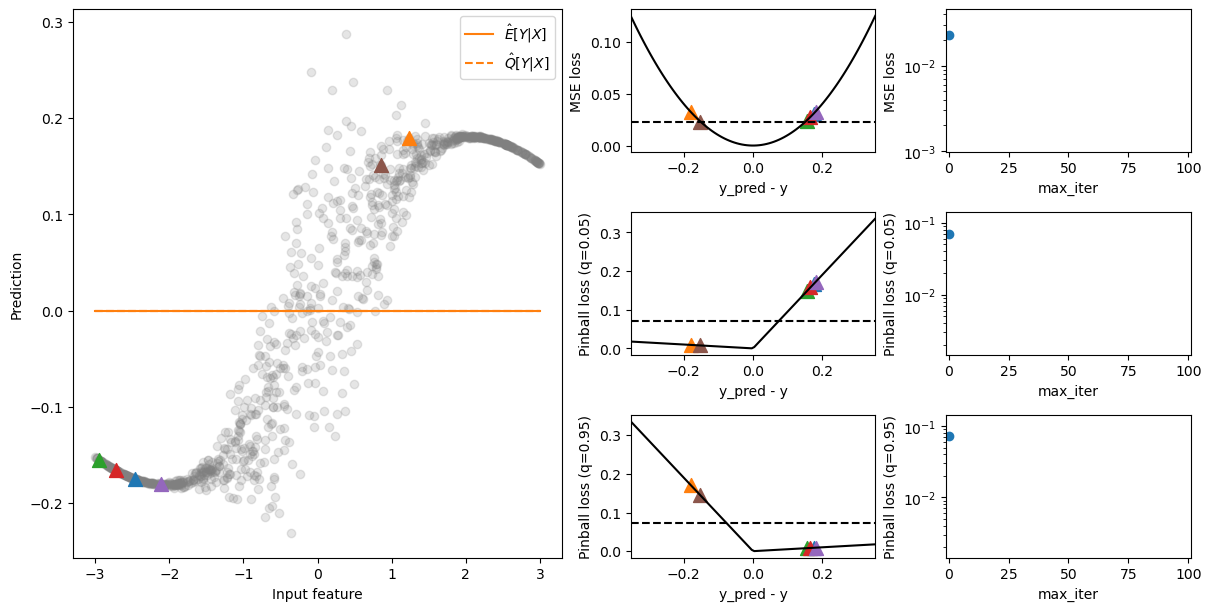

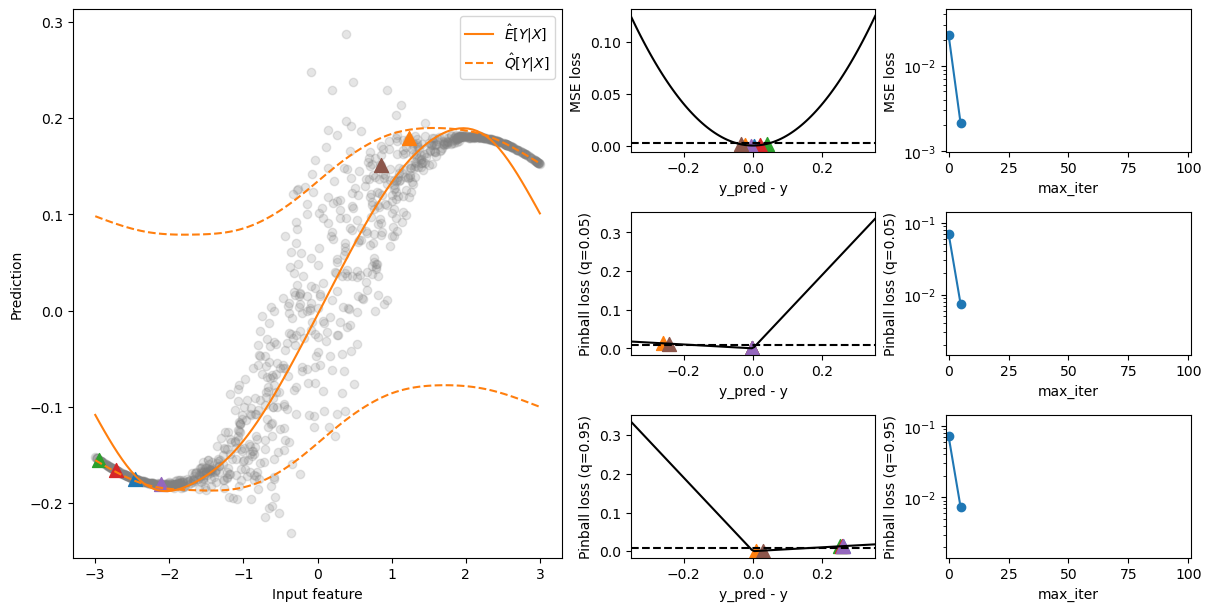

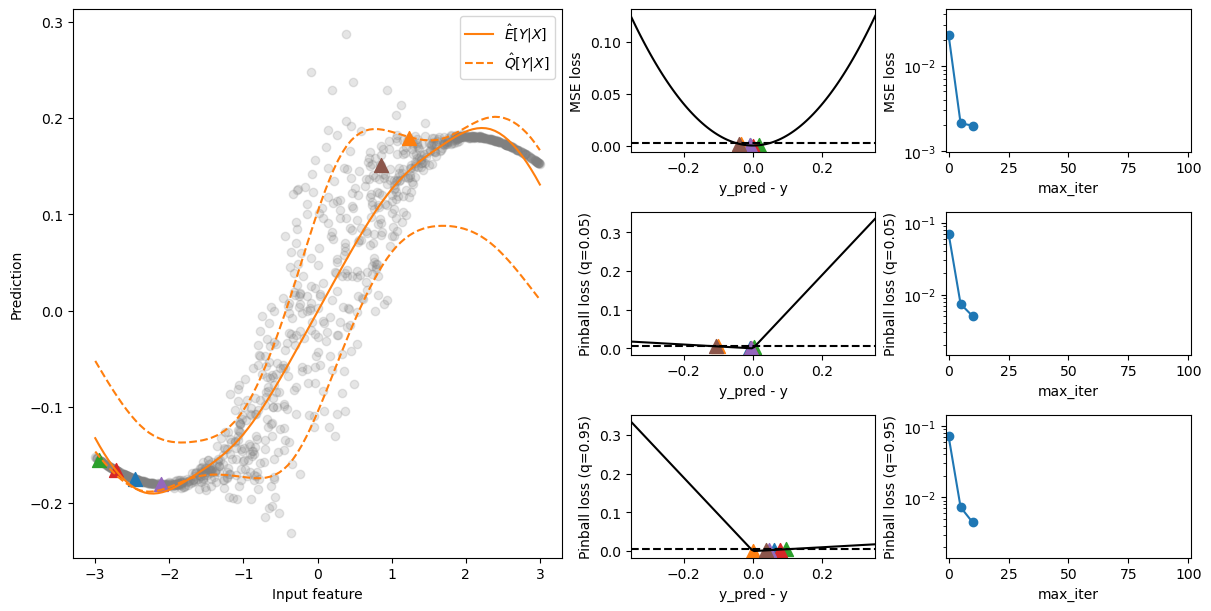

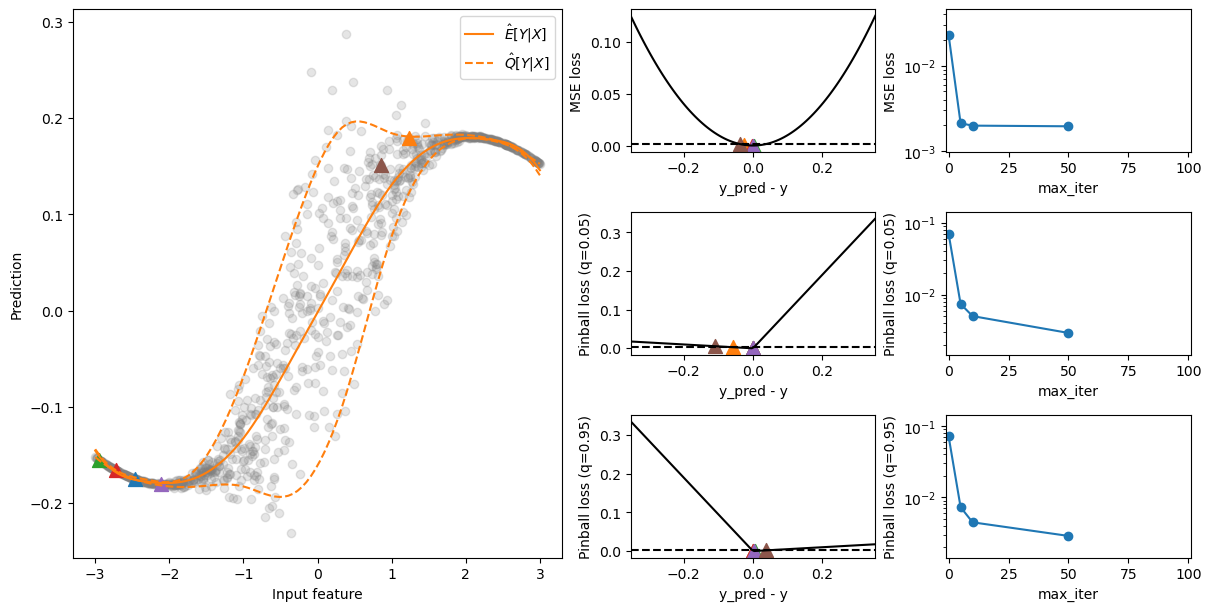

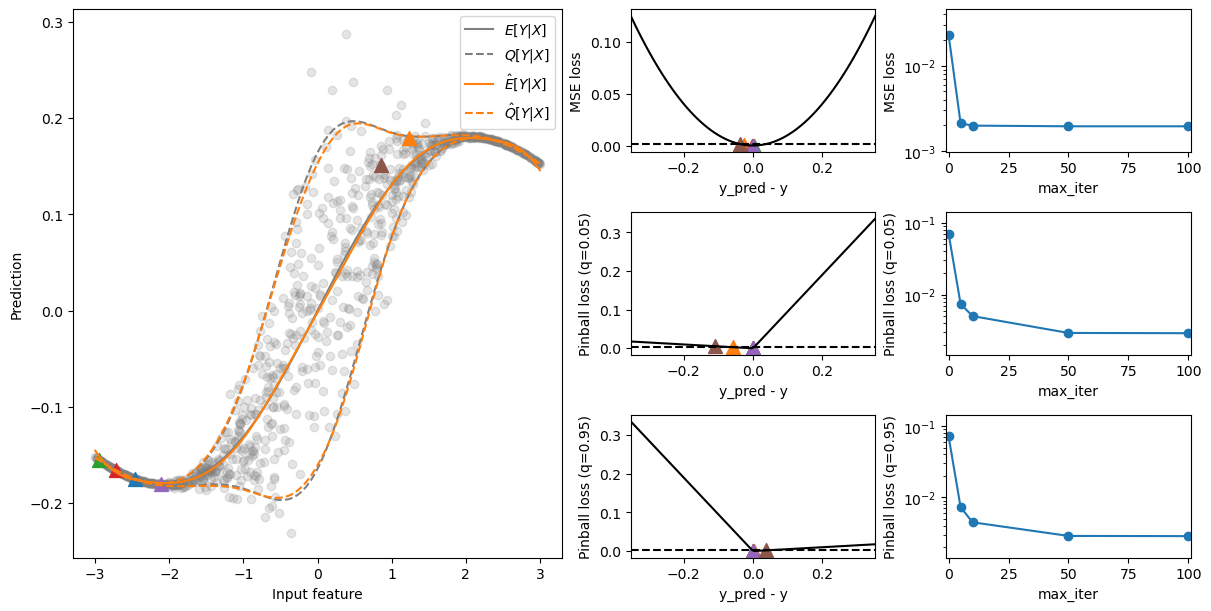

In [14]:
def loss_from_model(model):
    if hasattr(model, "steps"):
        model = model.steps[-1][1]
    return make_loss_function(model.loss, quantile=model.quantile)


def plot_model_triplet(models, x, ax=None, color="C1"):
    x_grid = np.linspace(x.min(), x.max(), 100)
    X_grid = x_grid.reshape((x_grid.shape[0], 1))
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    ax.plot(x_grid, models[0].predict(X_grid), label=r"$\hat{E}[Y|X]$", color=color)
    ax.plot(
        x_grid,
        models[1].predict(X_grid),
        linestyle="--",
        color=color,
    )
    ax.plot(
        x_grid,
        models[2].predict(X_grid),
        linestyle="--",
        label=r"$\hat{Q}[Y|X]$",
        color=color,
    )
    ax.set(
        xlabel="Input feature",
        ylabel="Prediction",
    )
    ax.legend()


def plot_loss_curve(max_iters, models, X, y, display_step, ax=None):
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)
    loss_fun, loss_label = loss_from_model(models[0])
    max_iters = np.asarray(max_iters)
    loss_values = np.asarray([loss_fun(y, m.predict(X)) for m in models])

    ax.plot(max_iters[: display_step + 1], loss_values[: display_step + 1], marker="o")
    ax.set(
        xlabel="max_iter",
        ylabel=loss_label,
        yscale="log",
        xlim=(max_iters.min() - 1, max_iters.max() + 1),
        ylim=(loss_values.min() * 0.5, loss_values.max() * 2),
    )


def plot_curves(record, model_name):
    for display_step in range(len(record)):

        truncated_record = record[: display_step + 1]
        fig = plt.figure(figsize=(12, 6), layout="constrained")
        ax0 = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=2)
        ax1 = plt.subplot2grid((3, 4), (0, 2))
        ax2 = plt.subplot2grid((3, 4), (1, 2))
        ax3 = plt.subplot2grid((3, 4), (2, 2))

        ax4 = plt.subplot2grid((3, 4), (0, 3))
        ax5 = plt.subplot2grid((3, 4), (1, 3))
        ax6 = plt.subplot2grid((3, 4), (2, 3))

        is_last_in_record = display_step == len(record) - 1
        plot_data_generating_process(
            x_train,
            y_train,
            highlight_indices=highlight_indices,
            plot_mean=is_last_in_record,
            plot_005_quantile=is_last_in_record,
            plot_095_quantile=is_last_in_record,
            ax=ax0,
        )
        plot_model_triplet(truncated_record[-1]["model_triplet"], x_train, ax=ax0)
        for model_idx, (ax_loss_fun, ax_loss_curve) in enumerate(
            [(ax1, ax4), (ax2, ax5), (ax3, ax6)],
        ):
            last_model = truncated_record[-1]["model_triplet"][model_idx]
            plot_loss_function(
                *loss_from_model(last_model),
                y_train,
                last_model.predict(X_train),
                highlight_indices=highlight_indices,
                legend=False,
                ax=ax_loss_fun,
            )

            plot_loss_curve(
                [r["max_iter"] for r in poly_reg_record],
                [r["model_triplet"][model_idx] for r in poly_reg_record],
                X_train,
                y_train,
                display_step,
                ax=ax_loss_curve,
            )
        fig.savefig(
            f"probabilistic_regression_curves_step"
            f"_{model_name.lower().replace(" ", "_")}_{display_step:02d}.png"
        )


plot_curves(poly_reg_record, "Polynomial Regressor")

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from threadpoolctl import threadpool_limits

shared_params = dict(max_leaf_nodes=5)
hgbt_reg_record = []
hgbt_reg_max_iters = [1, 5, 10, 50, 100]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    with threadpool_limits(limits=1):
        for max_iter in hgbt_reg_max_iters:
            shared_params["max_iter"] = max_iter
            model_triplet = (
                HistGradientBoostingRegressor(**shared_params).fit(X_train, y_train),
                HistGradientBoostingRegressor(
                    loss="quantile", quantile=0.05, **shared_params
                ).fit(X_train, y_train),
                HistGradientBoostingRegressor(
                    loss="quantile", quantile=0.95, **shared_params
                ).fit(X_train, y_train),
            )
            print(tuple(int(e.n_iter_) for e in model_triplet))
            hgbt_reg_record.append(
                dict(
                    max_iter=max_iter,
                    model_triplet=model_triplet,
                )
            )

(1, 1, 1)
(5, 5, 5)
(10, 10, 10)
(50, 50, 50)
(100, 100, 100)


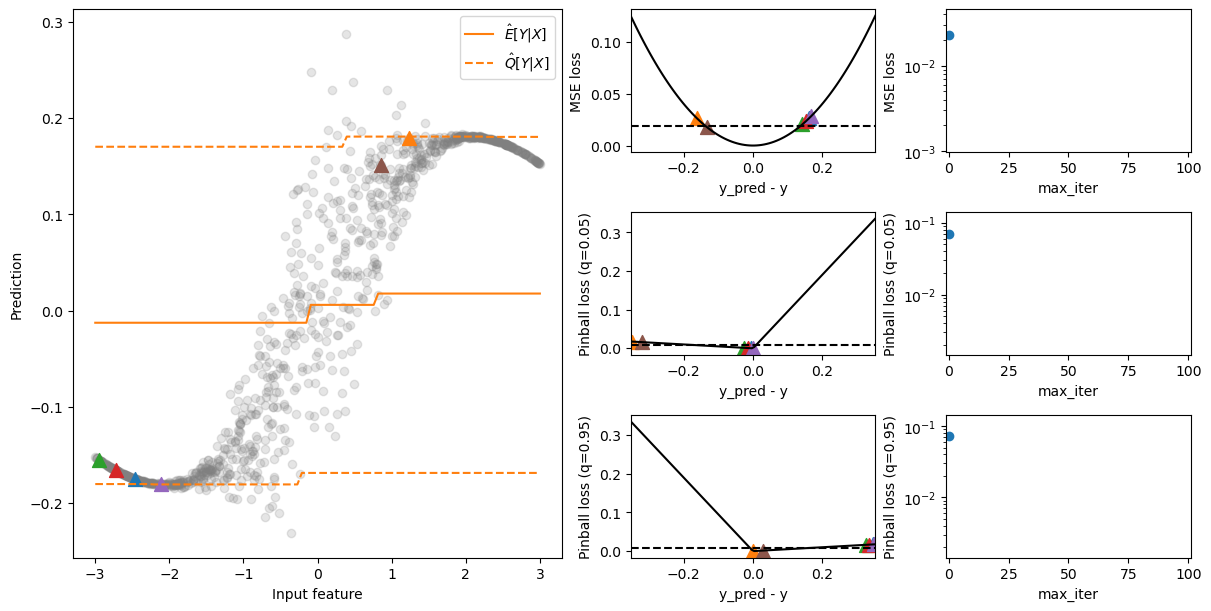

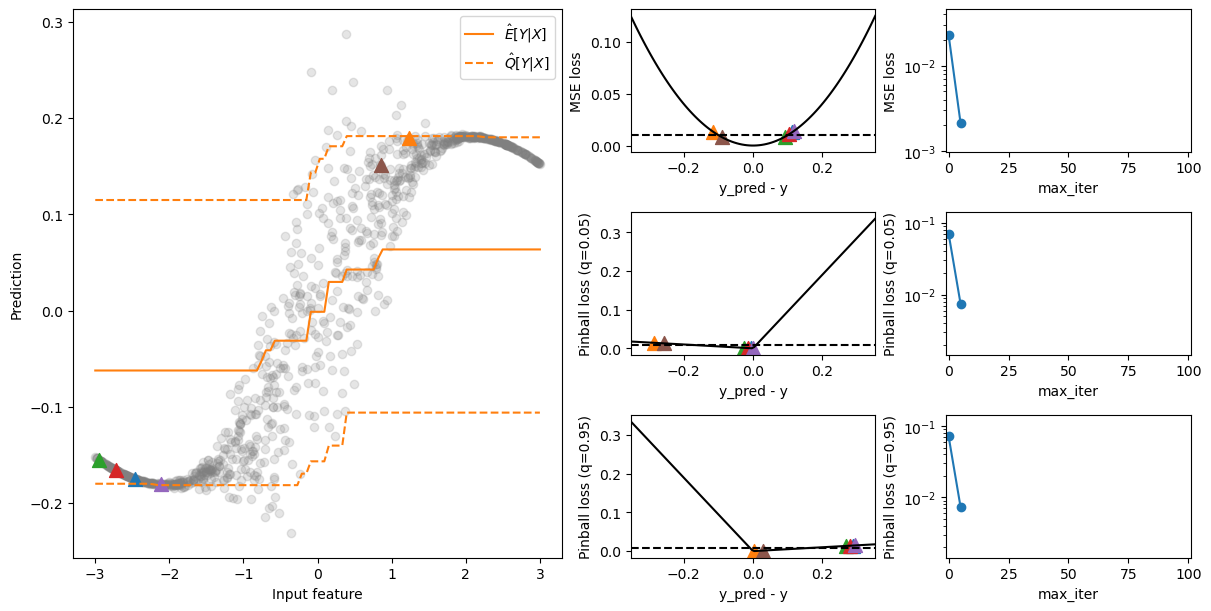

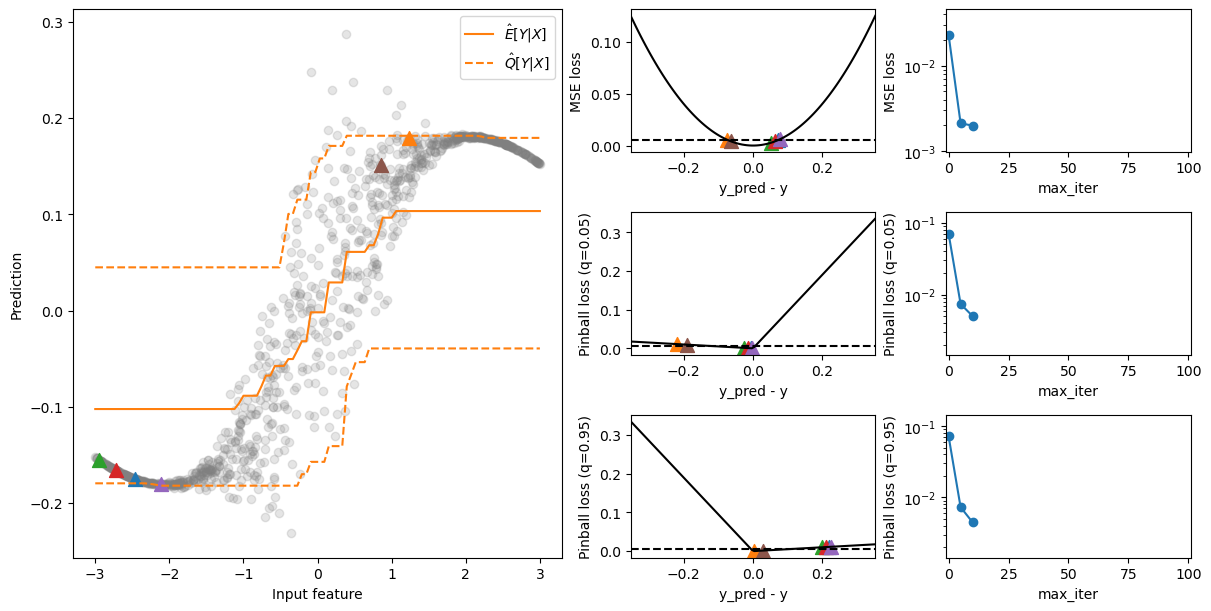

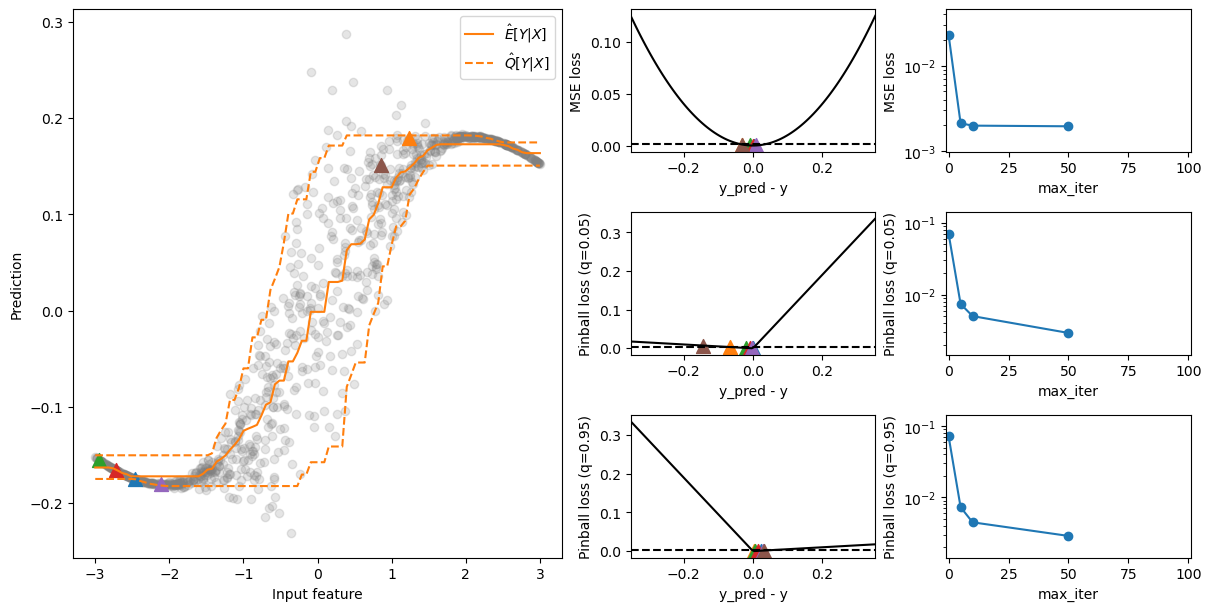

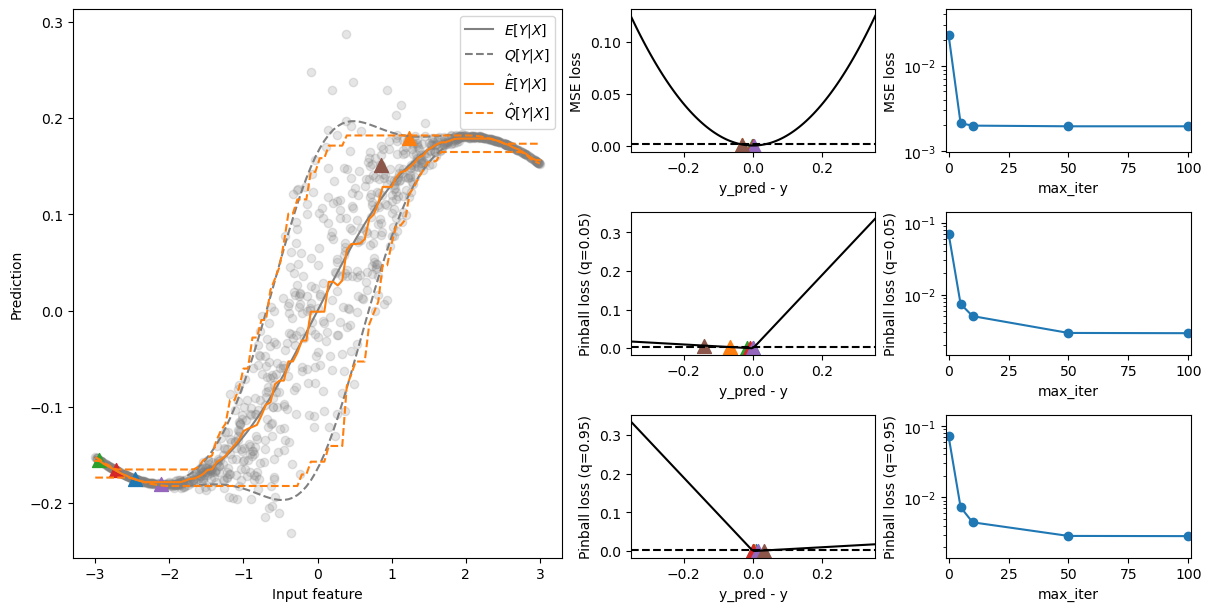

In [18]:
plot_curves(hgbt_reg_record, "HGBDT")